In [43]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

from keras.optimizers import SGD, rmsprop

from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In this program, We'll demonstrate both transfer learning and fine-tuning. We can use either or both if we like.

1. **Transfer learning:** freeze all but the penultimate layer and re-train the last Dense layer
2. **Fine-tuning:** un-freeze the lower convolutional layers and retrain more layers

Doing both, in that order, will ensure a more stable and consistent training. This is because the large gradient updates triggered by randomly initialized weights could wreck the learned weights in the convolutional base if not frozen. Once the last layer has stabilized (transfer learning), then we move onto retraining more layers (fine-tuning).

In [4]:
im_width, im_height = 299, 299

In [5]:
epochs = 2
batch_size = 32

In [6]:
nb_train_samples = 20000
nb_valid_samples = 5000

In [7]:
train_data_dir = 'data/cats-vs-dogs/train/'
valid_data_dir = 'data/cats-vs-dogs/valid/'

In [8]:
# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
valid_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory = train_data_dir, 
    target_size = (im_width, im_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_data_dir, 
    target_size = (im_width, im_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
# setup base model from InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False) # exclude the top FC layer

In [13]:
print(base_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
for i, layer in enumerate(base_model.layers):
    print('Layer {0}: Name: {1}'.format(i, layer.name))

Layer 0: Name: input_1
Layer 1: Name: conv2d_1
Layer 2: Name: batch_normalization_1
Layer 3: Name: activation_1
Layer 4: Name: conv2d_2
Layer 5: Name: batch_normalization_2
Layer 6: Name: activation_2
Layer 7: Name: conv2d_3
Layer 8: Name: batch_normalization_3
Layer 9: Name: activation_3
Layer 10: Name: max_pooling2d_1
Layer 11: Name: conv2d_4
Layer 12: Name: batch_normalization_4
Layer 13: Name: activation_4
Layer 14: Name: conv2d_5
Layer 15: Name: batch_normalization_5
Layer 16: Name: activation_5
Layer 17: Name: max_pooling2d_2
Layer 18: Name: conv2d_9
Layer 19: Name: batch_normalization_9
Layer 20: Name: activation_9
Layer 21: Name: conv2d_7
Layer 22: Name: conv2d_10
Layer 23: Name: batch_normalization_7
Layer 24: Name: batch_normalization_10
Layer 25: Name: activation_7
Layer 26: Name: activation_10
Layer 27: Name: average_pooling2d_1
Layer 28: Name: conv2d_6
Layer 29: Name: conv2d_8
Layer 30: Name: conv2d_11
Layer 31: Name: conv2d_12
Layer 32: Name: batch_normalization_6
Layer 3

In [17]:
# Add new last FC layer
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(units=1024, activation='relu')(top_model) # new FC Layer, random init
predictions = Dense(units=2, activation='softmax')(top_model) # new softmax layer

In [18]:
final_model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# transfer learning
# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [20]:
final_model.compile(optimizer=rmsprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_trf_learn = final_model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_valid_samples // batch_size,
).history

Epoch 1/2
625/625 [==============================] - 431s 690ms/step - loss: 8.0367 - acc: 0.5005 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
625/625 [==============================] - 423s 676ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


**Plotting Train vs Validation Loss:**

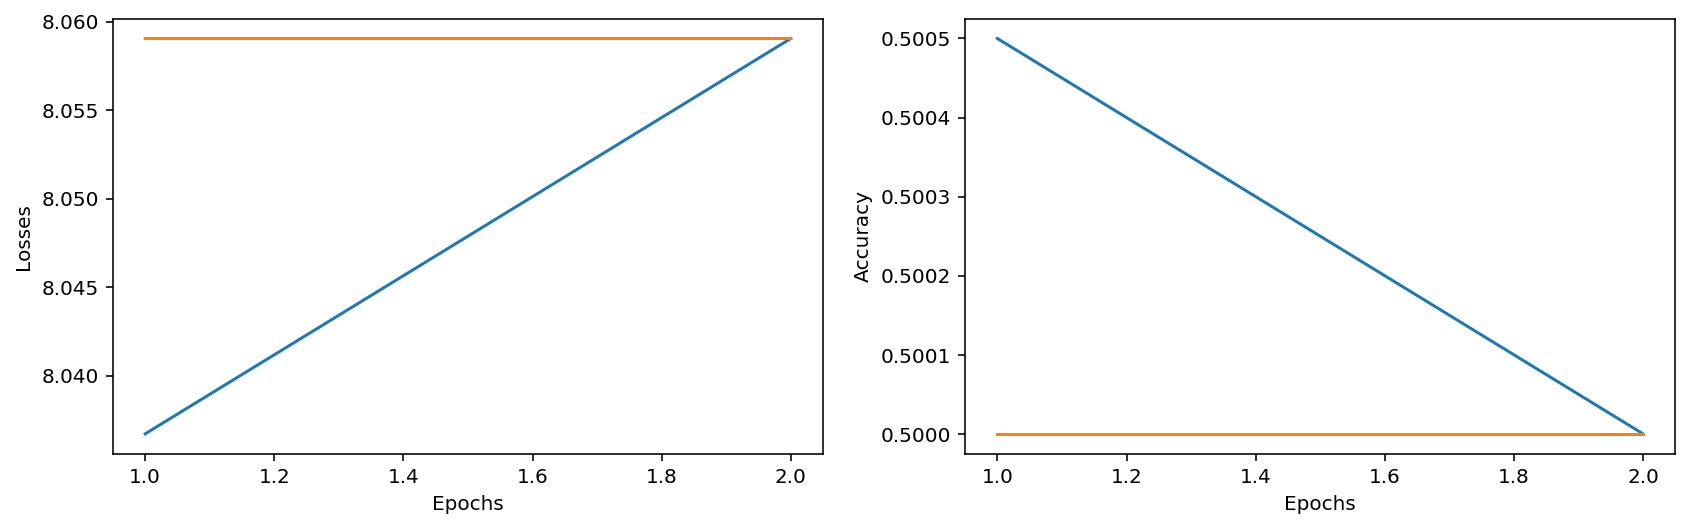

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history_trf_learn['loss'])
ax[0].plot(range(1, epochs + 1), history_trf_learn['val_loss'])
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
ax[1].plot(range(1, epochs + 1), history_trf_learn['acc'])
ax[1].plot(range(1, epochs + 1), history_trf_learn['val_acc'])
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')

In [26]:
# setup fine-tuning
# freeze some of the bottom layers and retrain the remaining top layers
for layer in final_model.layers[:172]:
    layer.trainable=False
for layer in final_model.layers[172:]:
    layer.trainable=True

When fine-tuning, it's important to lower the learning rate relative to the rate that was used when training from scratch (lr=0.0001), otherwise, the optimization could destabilize and the loss diverge.

In [27]:
final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history_fine_tune = final_model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=nb_valid_samples // batch_size,
).history

Epoch 1/2
625/625 [==============================] - 529s 847ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
625/625 [==============================] - 523s 837ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


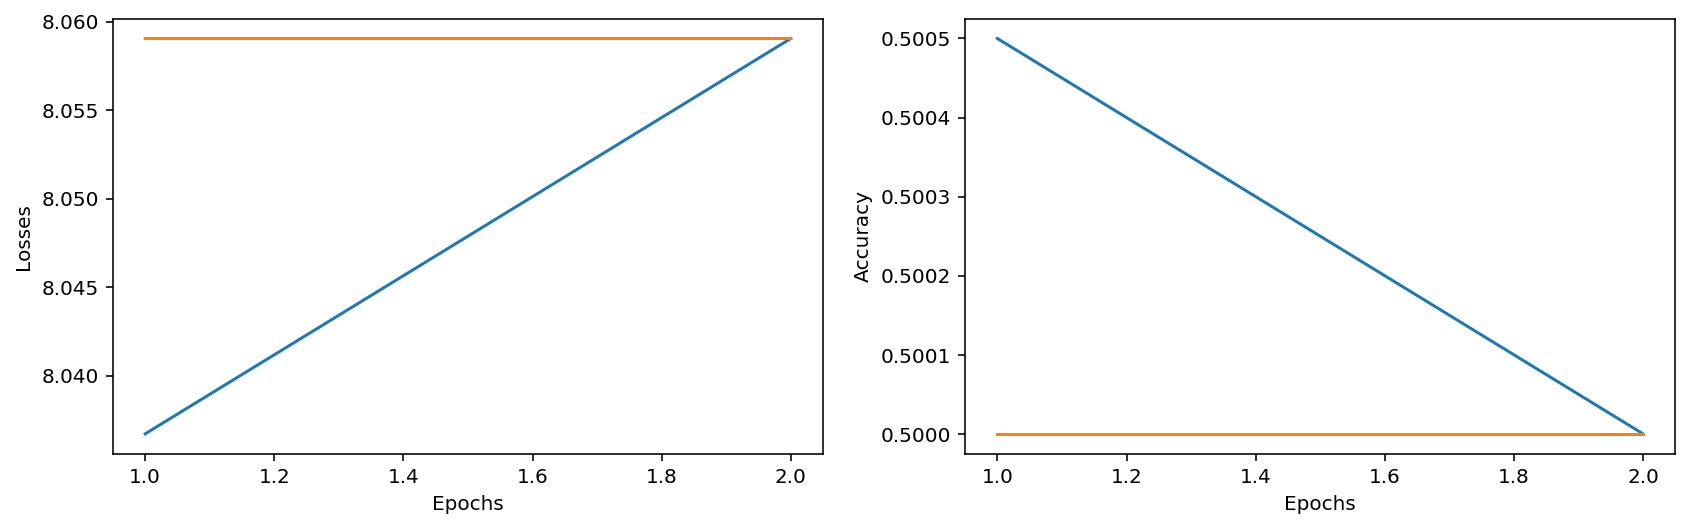

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history_trf_learn['loss'])
ax[0].plot(range(1, epochs + 1), history_trf_learn['val_loss'])
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
ax[1].plot(range(1, epochs + 1), history_trf_learn['acc'])
ax[1].plot(range(1, epochs + 1), history_trf_learn['val_acc'])
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')

In [31]:
final_model.save('model_weights/keras-transfer-learning-inceptionv3.h5')

In [32]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.inception_v3 import preprocess_input

from PIL import Image

In [33]:
target_size = (229, 229) #fixed size for InceptionV3 architecture

In [34]:
def predict(model, img, target_size):
    """Run model prediction on image
    Args:
    model: keras model
    img: PIL format image
    target_size: (w,h) tuple
    Returns:
    list of predicted labels and their probabilities
    """
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [35]:
def plot_preds(image, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
    image: PIL image
    preds: list of predicted labels and their probabilities
    """
    plt.imshow(image)
    plt.axis('off')

    plt.figure()
    labels = ("cat", "dog")
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.tight_layout()
    plt.show()

In [36]:
model = load_model('model_weights/keras-transfer-learning-inceptionv3.h5')

In [39]:
from glob import glob
img_cats = glob('data/cats-vs-dogs/train/cats/*.jpg')
img_dogs = glob('data/cats-vs-dogs/train/dogs/*.jpg')

In [48]:
np.random.permutation(img_dogs[:5] + img_cats[:5])

array(['data/cats-vs-dogs/train/dogs/dog.2090.jpg',
       'data/cats-vs-dogs/train/dogs/dog.4230.jpg',
       'data/cats-vs-dogs/train/cats/cat.54.jpg',
       'data/cats-vs-dogs/train/cats/cat.9011.jpg',
       'data/cats-vs-dogs/train/dogs/dog.911.jpg',
       'data/cats-vs-dogs/train/dogs/dog.8728.jpg',
       'data/cats-vs-dogs/train/cats/cat.10412.jpg',
       'data/cats-vs-dogs/train/cats/cat.2400.jpg',
       'data/cats-vs-dogs/train/dogs/dog.3290.jpg',
       'data/cats-vs-dogs/train/cats/cat.1935.jpg'], 
      dtype='<U42')

In [75]:
n_test = 8
in_imgs = np.random.permutation(img_dogs[:n_test//2] + img_cats[:n_test//2])
preds = [predict(model, Image.open(img), target_size) for img in in_imgs]

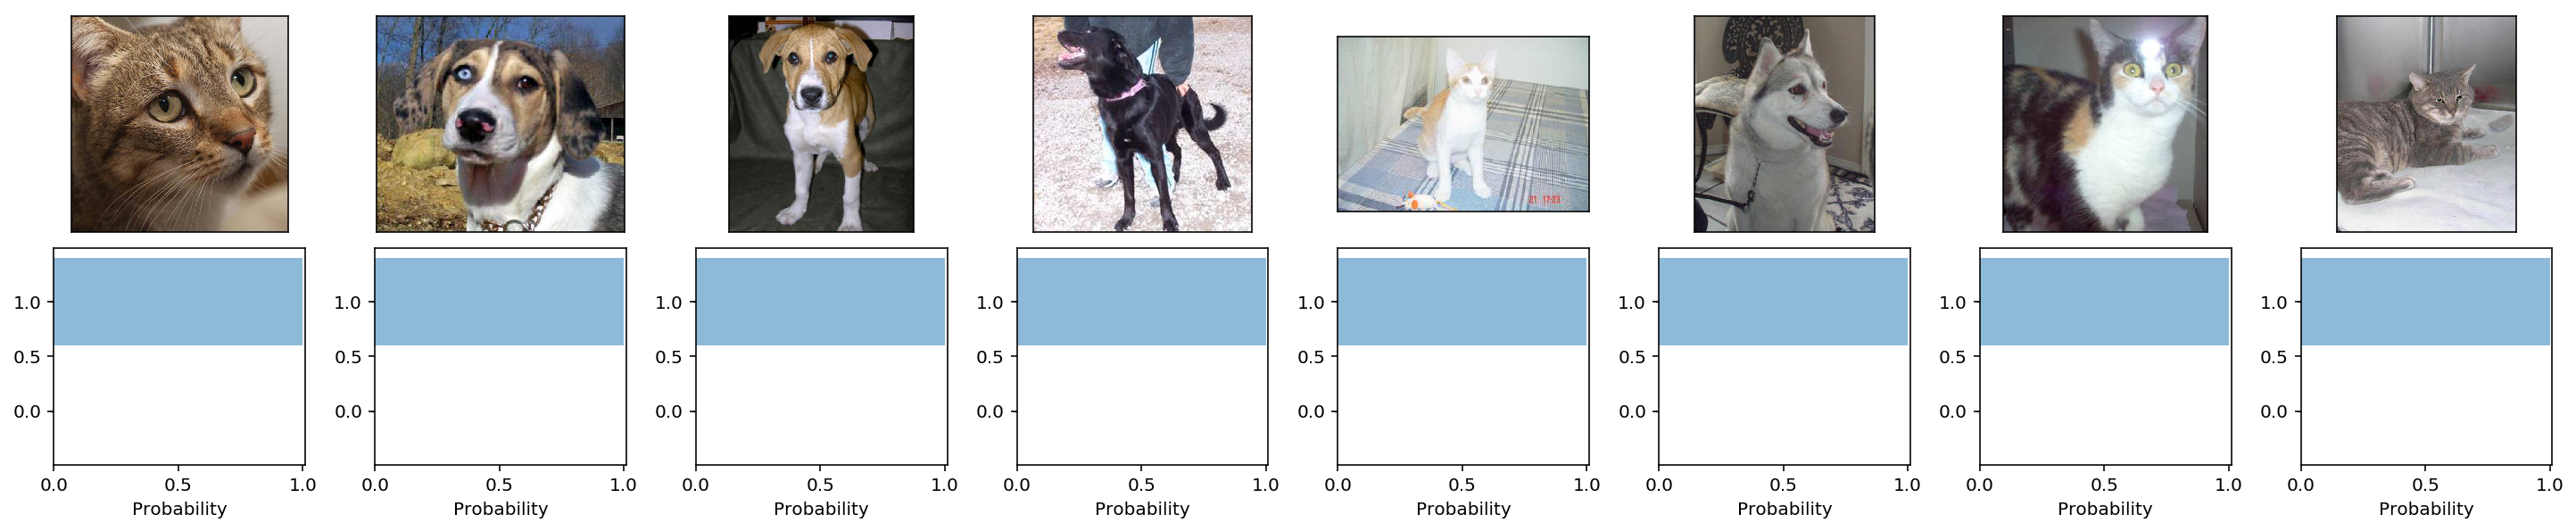

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=n_test, sharex=False, sharey=False, figsize=(20,4))
labels = ("cat", "dog")
for i in range(n_test):
    axes[0, i].imshow(Image.open(in_imgs[i]))
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    
    axes[1, i].barh([0, 1], preds[i], alpha=0.5)
    axes[1, i].set_yticks([0, 1], ("cat", "dog"))
    axes[1, i].set_xlabel('Probability')
    axes[1, i].set_xlim(0,1.01)
fig.tight_layout(pad=0.1)